In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **consommation** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (chauffage).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_D.csv',
                usecols = ['Dates', 'Consommation'])
df.head(1)

,Dates,Consommation
0,2013-01-01,54467.220833


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

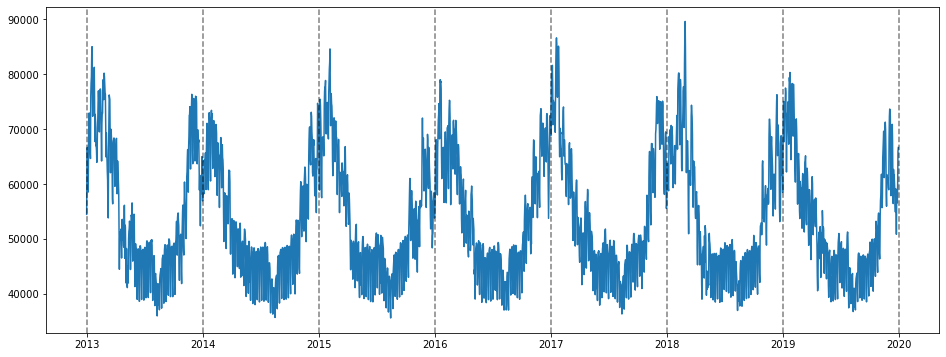

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(df[(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [6]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df)

(-4.40971718060884,
 0.0002852968421047051,
 29,
 3196,
 {'1%': -3.432397734657946,
  '5%': -2.862444764925196,
  '10%': -2.567251626693097},
 57562.16749945019)

### Coéfficients SARIMAX et saisonnalités

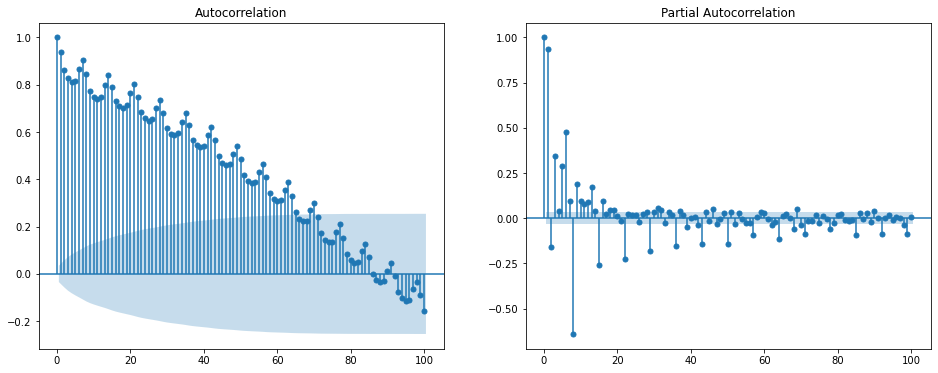

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df, lags = 100, ax=ax1)
plot_pacf(df, lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 7 jours
* 1 an

# Import du dataset filtré (Transformation de Fourier)

In [8]:
df_filtered = pd.read_csv('./dataset/France_D_filtered.csv',
                usecols = ['Dates', 'Consommation'])
df_filtered.head(1)

,Dates,Consommation
0,2013-01-01,59593.969284


In [9]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [10]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

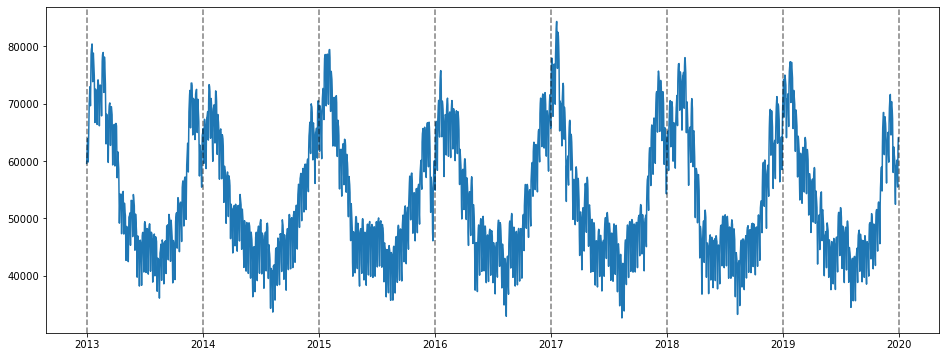

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

# Jeux d'entrainement et de test

In [12]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [13]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [14]:
fenetre = df_test.shape[0]

In [15]:
indice = df_test.index

In [16]:
bilan = df_test

# Paramètres SARIMAX

In [17]:
ordre = (2,0,0)
saison = (1,0,0,7)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [18]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25)
exog.set_index('date', inplace = True)

In [19]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-20-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

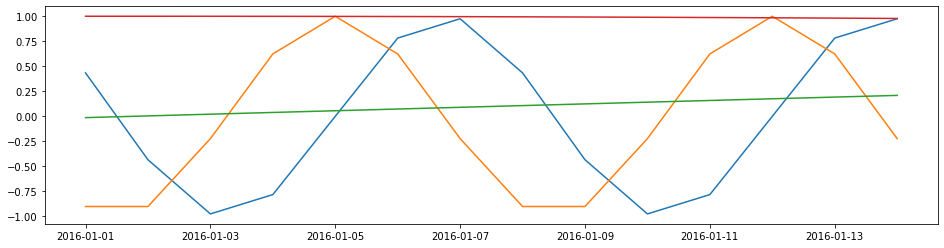

In [20]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [21]:
model_sinus = sm.tsa.SARIMAX(df_train.values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

In [22]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [23]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Conso_p_sinus'], index = indice)

In [24]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [25]:
bilan['Err_sinus'] = np.abs(bilan['Conso_p_sinus'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus
count,670.000000,670.000000,670.000000
mean,51020.506312,53482.388683,4961.778942
std,10139.836945,11164.785411,4728.300131
min,35502.375000,32808.380088,18.923790
25%,43686.817708,45970.249301,1475.233399
50%,47280.010417,49667.642405,3141.218507
75%,58345.692708,61978.710648,7519.986168
max,80476.166667,81517.573789,26158.241279


# Régresseurs exogènes : données métier

In [26]:
exog = pd.read_csv('./exog/exog_D_FR.csv', sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01,-7.246291


In [27]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [28]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [29]:
model_exog = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [30]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2556
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -24826.299
Date:                           Wed, 04 May 2022   AIC                          49662.597
Time:                                   10:25:24   BIC                          49691.828
Sample:                                        0   HQIC                         49673.197
                                          - 2556                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           571.3829     65.198      8.764      0.000     443.596     699.169
ar.L1          1.0859      0.055     19.651      0.000       0.978       1.194
ar.L2         -0.1051      0.055     -1.900      0.057      -0.214       0.003
ar.S.L7        0.8128      0.034     23.597      0.000       0.745       0.880
sigma2      3.805e+07      0.000   1.98e+11      0.000     3.8e+07     3.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               529.19
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.27
Prob(H) (two-sided):                  0.94   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 3.87e+27. Standard errors may be unstable.
"""

In [32]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [33]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Conso_p_exog'])

In [34]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [35]:
bilan['Err_exog'] = np.abs(bilan['Conso_p_exog'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,51020.506312,53482.388683,4961.778942,53615.767017,5048.200800
std,10139.836945,11164.785411,4728.300131,11164.267012,4680.278773
min,35502.375000,32808.380088,18.923790,32747.675674,6.291166
25%,43686.817708,45970.249301,1475.233399,45635.283488,1564.805542
50%,47280.010417,49667.642405,3141.218507,49527.693936,3529.516478
75%,58345.692708,61978.710648,7519.986168,62648.614130,7342.064310
max,80476.166667,81517.573789,26158.241279,81685.099202,25041.947836


# Régresseurs exogènes : données métier FILTREES

In [36]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01,-7.405577


In [37]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [38]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [39]:
model_filter = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [40]:
result_filter = model_filter.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2556
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -24685.550
Date:                           Wed, 04 May 2022   AIC                          49381.101
Time:                                   10:25:36   BIC                          49410.332
Sample:                                        0   HQIC                         49391.701
                                          - 2556                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           545.7663     64.018      8.525      0.000     420.294     671.238
ar.L1          1.0045      0.053     18.868      0.000       0.900       1.109
ar.L2         -0.1869      0.052     -3.565      0.000      -0.290      -0.084
ar.S.L7        0.9762      0.010     99.340      0.000       0.957       0.995
sigma2      3.342e+07      0.000    3.3e+11      0.000    3.34e+07    3.34e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.69   Jarque-Bera (JB):               611.40
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.15
Prob(H) (two-sided):                  0.86   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.64e+27. Standard errors may be unstable.
"""

In [42]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [43]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Conso_p_filter'])

In [44]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [45]:
bilan['Err_exog_filter'] = np.abs(bilan['Conso_p_filter'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,51020.506312,53482.388683,4961.778942,53615.767017,5048.200800,53517.932394,5020.087934
std,10139.836945,11164.785411,4728.300131,11164.267012,4680.278773,11111.002770,4651.604116
min,35502.375000,32808.380088,18.923790,32747.675674,6.291166,32874.767221,16.620599
25%,43686.817708,45970.249301,1475.233399,45635.283488,1564.805542,45930.851350,1515.385404
50%,47280.010417,49667.642405,3141.218507,49527.693936,3529.516478,49656.631309,3423.730506
75%,58345.692708,61978.710648,7519.986168,62648.614130,7342.064310,62166.122108,7284.628061
max,80476.166667,81517.573789,26158.241279,81685.099202,25041.947836,81091.534479,25569.382109


# Target FILTREE sans régresseur

### SARIMAX

In [46]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter.values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [47]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

In [48]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2556
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -16720.391
Date:                           Wed, 04 May 2022   AIC                          33448.783
Time:                                   10:25:40   BIC                          33472.167
Sample:                                        0   HQIC                         33457.263
                                          - 2556                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9456        nan        nan        nan         nan         nan
ar.L2         -1.0000        nan        nan        nan         nan         nan
ar.S.L7        1.0000   4.44e-06   2.25e+05      0.000       1.000       1.000
sigma2        2.7e+04        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                2012.52   Jarque-Bera (JB):                39.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.02
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 4.66e+35. Standard errors may be unstable.
"""

In [49]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [50]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Conso_p_reduit_noreg'])

In [51]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [52]:
bilan['Err_filter_noreg'] = np.abs(bilan['Conso_p_reduit_noreg'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,51020.506312,53482.388683,4961.778942,53615.767017,5048.200800,53517.932394,5020.087934,53817.451625,4655.802518
std,10139.836945,11164.785411,4728.300131,11164.267012,4680.278773,11111.002770,4651.604116,10739.776934,4492.621678
min,35502.375000,32808.380088,18.923790,32747.675674,6.291166,32874.767221,16.620599,33731.727170,12.020670
25%,43686.817708,45970.249301,1475.233399,45635.283488,1564.805542,45930.851350,1515.385404,45810.757867,1307.008012
50%,47280.010417,49667.642405,3141.218507,49527.693936,3529.516478,49656.631309,3423.730506,50315.225878,3051.707998
75%,58345.692708,61978.710648,7519.986168,62648.614130,7342.064310,62166.122108,7284.628061,63022.357412,6463.804892
max,80476.166667,81517.573789,26158.241279,81685.099202,25041.947836,81091.534479,25569.382109,80332.762985,21845.804902


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [53]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01,-7.405577


In [54]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [55]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [56]:
model_reduit = sm.tsa.SARIMAX(df_train_filter.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [57]:
result_reduit = model_reduit.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2556
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -24011.518
Date:                           Wed, 04 May 2022   AIC                          48033.035
Time:                                   10:25:58   BIC                          48062.266
Sample:                                        0   HQIC                         48043.636
                                          - 2556                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           551.8479     48.222     11.444      0.000     457.334     646.362
ar.L1          1.7382      0.032     55.083      0.000       1.676       1.800
ar.L2         -0.9999    9.6e-05  -1.04e+04      0.000      -1.000      -1.000
ar.S.L7        0.9994      0.000   2991.508      0.000       0.999       1.000
sigma2      2.071e+07      0.002   1.21e+10      0.000    2.07e+07    2.07e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.55   Prob(JB):                         0.26
Heteroskedasticity (H):               1.12   Skew:                             0.01
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.55e+25. Standard errors may be unstable.
"""

In [59]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [60]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Conso_p_reduit'])

In [61]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [62]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Conso_p_reduit'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg,Conso_p_reduit,Err_filter_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,51020.506312,53482.388683,4961.778942,53615.767017,5048.200800,53517.932394,5020.087934,53817.451625,4655.802518,53685.037635,4785.819267
std,10139.836945,11164.785411,4728.300131,11164.267012,4680.278773,11111.002770,4651.604116,10739.776934,4492.621678,10697.143386,4689.468354
min,35502.375000,32808.380088,18.923790,32747.675674,6.291166,32874.767221,16.620599,33731.727170,12.020670,32787.349037,5.721638
25%,43686.817708,45970.249301,1475.233399,45635.283488,1564.805542,45930.851350,1515.385404,45810.757867,1307.008012,45752.350433,1248.158648
50%,47280.010417,49667.642405,3141.218507,49527.693936,3529.516478,49656.631309,3423.730506,50315.225878,3051.707998,49799.202863,3163.128430
75%,58345.692708,61978.710648,7519.986168,62648.614130,7342.064310,62166.122108,7284.628061,63022.357412,6463.804892,62804.570521,6910.505890
max,80476.166667,81517.573789,26158.241279,81685.099202,25041.947836,81091.534479,25569.382109,80332.762985,21845.804902,79791.834769,24379.424931


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [63]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01,-7.405577


In [64]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [65]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [66]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train)
predict_lr = LinReg.predict(exog_test)

In [67]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Conso_p_LinReg'])

In [68]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [69]:
bilan['Err_LinReg'] = np.abs(bilan['Conso_p_LinReg'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg,Conso_p_reduit,Err_filter_exog_filter,Conso_p_LinReg,Err_LinReg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,51020.506312,53482.388683,4961.778942,53615.767017,5048.200800,53517.932394,5020.087934,53817.451625,4655.802518,53685.037635,4785.819267,53237.683316,5061.776086
std,10139.836945,11164.785411,4728.300131,11164.267012,4680.278773,11111.002770,4651.604116,10739.776934,4492.621678,10697.143386,4689.468354,8888.966935,3554.876084
min,35502.375000,32808.380088,18.923790,32747.675674,6.291166,32874.767221,16.620599,33731.727170,12.020670,32787.349037,5.721638,32027.785906,23.883773
25%,43686.817708,45970.249301,1475.233399,45635.283488,1564.805542,45930.851350,1515.385404,45810.757867,1307.008012,45752.350433,1248.158648,45716.340697,2159.056652
50%,47280.010417,49667.642405,3141.218507,49527.693936,3529.516478,49656.631309,3423.730506,50315.225878,3051.707998,49799.202863,3163.128430,53881.610552,4407.319190
75%,58345.692708,61978.710648,7519.986168,62648.614130,7342.064310,62166.122108,7284.628061,63022.357412,6463.804892,62804.570521,6910.505890,60196.552090,7286.241108
max,80476.166667,81517.573789,26158.241279,81685.099202,25041.947836,81091.534479,25569.382109,80332.762985,21845.804902,79791.834769,24379.424931,74100.413225,15222.399662


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [70]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01,-7.405577


In [71]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [72]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [73]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter)
predict_lr_filter = LinReg_filter.predict(exog_test)

In [74]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Conso_p_LinReg_filter'])

In [75]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [76]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Conso_p_LinReg_filter'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg,Conso_p_reduit,Err_filter_exog_filter,Conso_p_LinReg,Err_LinReg,Conso_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,51020.506312,53482.388683,4961.778942,53615.767017,5048.200800,53517.932394,5020.087934,53817.451625,4655.802518,53685.037635,4785.819267,53237.683316,5061.776086,53272.468040,5070.066213
std,10139.836945,11164.785411,4728.300131,11164.267012,4680.278773,11111.002770,4651.604116,10739.776934,4492.621678,10697.143386,4689.468354,8888.966935,3554.876084,8570.840802,3530.916977
min,35502.375000,32808.380088,18.923790,32747.675674,6.291166,32874.767221,16.620599,33731.727170,12.020670,32787.349037,5.721638,32027.785906,23.883773,32821.649014,35.346361
25%,43686.817708,45970.249301,1475.233399,45635.283488,1564.805542,45930.851350,1515.385404,45810.757867,1307.008012,45752.350433,1248.158648,45716.340697,2159.056652,46020.305818,2139.110746
50%,47280.010417,49667.642405,3141.218507,49527.693936,3529.516478,49656.631309,3423.730506,50315.225878,3051.707998,49799.202863,3163.128430,53881.610552,4407.319190,53893.349844,4395.699115
75%,58345.692708,61978.710648,7519.986168,62648.614130,7342.064310,62166.122108,7284.628061,63022.357412,6463.804892,62804.570521,6910.505890,60196.552090,7286.241108,59982.286723,7385.418664
max,80476.166667,81517.573789,26158.241279,81685.099202,25041.947836,81091.534479,25569.382109,80332.762985,21845.804902,79791.834769,24379.424931,74100.413225,15222.399662,73388.544299,15266.071670


# Visualisation réel vs prédictions

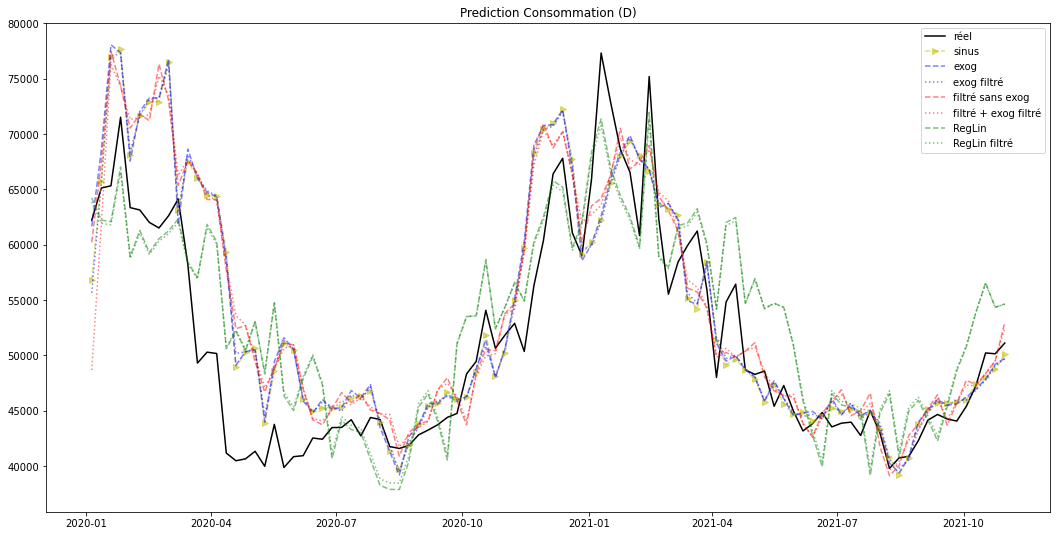

In [77]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Consommation'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Conso_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Conso_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Conso_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Conso_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Conso_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Conso_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Conso_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Consommation (D)')
plt.savefig('./results/pred_consommation_D.png');

# Synthèse des erreurs

In [79]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4961.778942,5048.200800,5020.087934,4655.802518,4785.819267,5061.776086,5070.066213
std,4728.300131,4680.278773,4651.604116,4492.621678,4689.468354,3554.876084,3530.916977
min,18.923790,6.291166,16.620599,12.020670,5.721638,23.883773,35.346361
25%,1475.233399,1564.805542,1515.385404,1307.008012,1248.158648,2159.056652,2139.110746
50%,3141.218507,3529.516478,3423.730506,3051.707998,3163.128430,4407.319190,4395.699115
75%,7519.986168,7342.064310,7284.628061,6463.804892,6910.505890,7286.241108,7385.418664
max,26158.241279,25041.947836,25569.382109,21845.804902,24379.424931,15222.399662,15266.071670


In [80]:
bilan.to_csv('./results/bilan_consommation_D.csv', sep = ';')
erreur.to_csv('./results/erreur_consommation_D.csv', sep = ';')